In [1]:
#Line fitting
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from scipy.interpolate import Akima1DInterpolator
from scipy import optimize as opt
import sys
import emcee
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import csv
from astropy.table import Table
from astropy import table
from astropy.table import unique, Table
import glob
from astropy.table import QTable
import astropy.units as u
#1875nm resting


In [4]:
                                            #OFFICE HOURS QUESTIONS
#what to look for for paschen alpha without redshift (like any nearby lines or whatever)
#Next Steps?
#Any questions about new rubies sources (am I looking for something specific or just making sure it works)
#Questions: Do I need to define Amp_Max?
#What is first_wave? (like is that mu again or is it denoting a specific gaussian in case you fit more than one?)
#what is 'wave'?
#what is err_spec? goes along with what is spec? is it just the flux again or? because I thought yerr was that or is it twice
#is line center a parameter or is it what it is guessing the line center is? 

In [5]:
# FITTING RUBIES DATA
RubiesList = glob.glob('*PRIMER-UDS*')
# RubiesList

In [8]:
TableTylerCat = Table.read('TylerCatalog-Copy1.ecsv')
TableTylerCat['MSA_ID']

41330

In [2]:
def gaussian(x, A, mu, sigma):
    '''
    Gaussian Model for Line Fitting. We have parameters:
    
    x: wavelength of the spectra
    A: Amplitude of the gaussian
    mu: Center of the gaussian
    sigma: the width of the gaussian
    
    
    Return:
    An array fo the same length as x but of the Gaussian based of parameters A, mu, and sigma
    '''
    
    return A * np.exp(-(x - mu)**2/ (sigma**2))

def line(x, b):
    
    '''
    Continuum of the spectra
    
    For right now we are assuming it is a straight line y = b with b being the free parameter here
    '''
    
    return  np.ones(len(x))*b

def line_model(x, A, mu, sigma, b):
    
    '''
    Emission Line model using Gaussian and the continuum
    
    The full model for the emission line here we sum up the the gaussian and continuum to get our full emission line model
    '''
    gauss = gaussian(x, A, mu, sigma)
    l = line(x, b)
    
#     print(gauss.shape)
#     print(l.shape)
    
    return gauss + l

def log_likelihood(theta, x, y, yerr):
    ################
    
    # The value we are trying to fit
    #A, mu, sigma, m, b = theta
    #=
    
    #Making the model of the emission line
    model = line_model(x, *theta)
    
    #getting the log likelihood, this is similar to chi2
    lnL = -0.5 * np.sum((y - model) ** 2 / yerr**2)
    
   
    
    return lnL

# def Chi(y, model):
#     chi = np.sum((y - model) ** 2 / model **2)
#     return chi

def log_prior(theta, wave_center, Amp_max):
    #Theta values that goes into our Gaussian Model
    A, mu, sigma,b = theta
    
    #the left most and right most the central wavelength can vary
    left_mu = wave_center - .04  #had to change these as well this is how much mu can vary
    right_mu = wave_center + .04 #had to change these as well this is how much mu can vary (.04 is updated for wfss)
    
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
   
    
    sigma_window_left = .0001 #had to change these for the input spectra these are left bounds for sigma (updated for wfss 10x)
    sigma_window_right = .005 #had to change these for the input spectra these are right bounds for sigma
        
    if (0 < A < max_A) & (left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > 0):
        return 0.0
    else:
        return -np.inf
    
def log_probability(theta, x, y, yerr, first_wave, Amp_max):
    
    lp = log_prior(theta, first_wave, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    prob = lp + log_likelihood(theta, x, y, yerr)
    #print(f'Prob:{prob:.3E}')
    return prob

def initial_fits(wave, spectrum, err_spec, window, line_center, diagnose = False):
    
    window_check = np.log10(window)
    
    if window_check > -2:
        print('WARNING: Search window may be too big double check input value')
    
    
    #the range where the optimization can look between 
    min_window = line_center - window
    max_window = line_center + window
    
    #getting emission line near the line center
    #line_center +/- window
    indx = np.where((min_window < wave) & ((wave < max_window)))[0]

    spec_window = spectrum[indx]
    #print(spec_window)
    wave_window = wave[indx]
    #print(wave_window)
    err_spec_window = err_spec[indx]
#     print(spec_window)
    
    #initial guesses for the optimization
    guess_A = np.amax(spectrum[indx])
    guess_mu = line_center
    
    print(guess_mu)
    
    spec_interp = Akima1DInterpolator(wave_window, spec_window)
    
    x = np.linspace(wave_window[0], wave_window[-1], 10000)
    
    spec = spec_interp(x)
    
    half_max = np.amax(spec)/2
    
    idx = np.where(spec > half_max)[0]
    
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    guess_sigma = (wave_right - wave_left)/2
    
    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"A: {guess_A}")
        print(f"mu: {guess_mu}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {np.ma.median(spec_window)}")
        print() 
        
    xarr = np.linspace(wave_window[0], wave_window[-1], 100)
    plt.figure()
    plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
    plt.scatter(wave_window, spec_window, color = 'blue')
    #plt.plot(xarr, line_model(xarr, *result), color = 'black', label = 'Model')
    plt.axhline(0, linestyle = '--')
    plt.ylabel('Flux')
    plt.xlabel(r'Wavelength $\mu$m')
    plt.title('Initial curve_fit Fitting')
    plt.legend()
    plt.show()
   

    
        
    x0 = [guess_A, guess_mu, guess_sigma, np.ma.median(spec_window)]
    

    low_bounds = [0, min_window, 0, np.ma.median(spec_window)/2] # np.median to np.ma.median due to 'partition' will ignore the 'mask' error
    high_bounds = [2*guess_A, max_window, .1, np.ma.median(spec_window)*2]
    print(np.ma.median(spec_window))
    print(low_bounds)
    print(x0)
    print(high_bounds)
    
    # Optimization of the initial gaussian fit
    result,_ = curve_fit(line_model, wave_window, spec_window, p0 = x0, 
                          bounds = [low_bounds, high_bounds])                 #bounds on b
    
    
    ########
    # Diagnostic Plotting: making sure we are getting the emission line
    ########
    if diagnose == True:
        
        print('Minimization Results')
        print(f"A: {result[0]}")
        print(f"mu: {result[1]}")
        print(f"sigma: {result[2]}")
        print(f"b: {result[3]}")
        print()
    
        
        
        xarr = np.linspace(wave_window[0], wave_window[-1], 100)
        plt.figure()
        plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
        plt.scatter(wave_window, spec_window, color = 'blue')
        plt.plot(xarr, line_model(xarr, *result), color = 'black', label = 'Model')
        plt.axhline(0, linestyle = '--')
        plt.ylabel('Flux')
        plt.xlabel(r'Wavelength $\mu$m')
        plt.title('Initial curve_fit Fitting')
        plt.legend()
        plt.show()
    
    
    return result


        
def fitting_line(wave, flux, flux_err, line_center, window_wavelength, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    
    result = initial_fits(wave, flux, flux_err, window_wavelength, line_center, diagnose = diagnose)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A = result[0]
    guess_mu = result[1]
    guess_sigma = result[2]
    guess_b = result[3]
    
    
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump = np.random.normal(loc = guess_A,            #centered on best A from minimization
                                scale = guess_A/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    
    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from minimization
                                       scale = .005,      #can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
    
    sigma_jump = np.random.normal(loc = guess_sigma, scale = .002, size = 32).reshape(-1, 1)

    
    powerb = np.log10(guess_b)
    
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)

    
    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    if diagnose == True:
        print('Checking the Walker Jumps')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        ax[0, 0].hist(amp_jump)
        ax[0, 0].set_xlabel('Amplitude')
        
        ax[0, 1].hist(wavelength_jump)
        ax[0, 1].set_xlabel(r'$\mu$')
        
        ax[1, 0].hist(sigma_jump)
        ax[1, 0].set_xlabel(r'$\sigma$')
        
        ax[1, 1].hist(b_jump)
        ax[1, 1].set_xlabel('b')
        
        plt.show()
    

    #stacking along the columns
    starting_walkers = np.hstack((amp_jump,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  #m_jump, 
                                  b_jump))
    
#The problem area is here: abs as test fix for prior error
    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength #in units of microns
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0]

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]
    
    
    ###########
    #NOTE:
    #need to change output name everytime you run otherwise it will overwrite
    ###########
    
    #saves the input emcee spectra
    emcee_spec_matrix = np.c_[emcee_wave, emcee_spec, emcee_err]
    np.savetxt(f'Emcee_Spectra_s06563.txt', emcee_spec_matrix)

    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])

    #running it
    sampler.run_mcmc(pos, 3000, progress=False)

    #getting values back
    #samples = sampler.get_chain()
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability
    burn_in = 1000 
    
    emcee_df = pd.DataFrame()
    emcee_df['A'] = flat_samples[burn_in:, 0]
    emcee_df['mu'] = flat_samples[burn_in:, 1]
    emcee_df['sigma'] = flat_samples[burn_in:, 2]
    emcee_df['b'] = flat_samples[burn_in:, 3]
    emcee_df['LnL'] = LnL_chain[burn_in:]
    
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    
    fluxes_emcee = emcee_df['A'] * emcee_df['sigma'] * np.sqrt(2 * np.pi)
    
    emcee_df['Fluxes'] = fluxes_emcee
    
#end of potential problem area
    
    if diagnose == True:
        
        print('Checking Parameter Posterior Distributions')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
#         emcee_df.A.hist(ax = ax[0, 0])
#         emcee_df.mu.hist(ax = ax[0, 1])
#         emcee_df.sigma.hist(ax = ax[1, 0])
#         emcee_df.m.hist(ax = ax[1, 0])
#         emcee_df.b.hist(ax = ax[1, 1])
        
        plt.show()

    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        
        
        plt.figure()
        plt.title('Input Emcee Spectra and Emcee Fit')
        plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
        
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return emcee_wave, emcee_spec, emcee_err, emcee_df

In [10]:
RubiesList = glob.glob('*PRIMER-UDS*')
# RubiesList

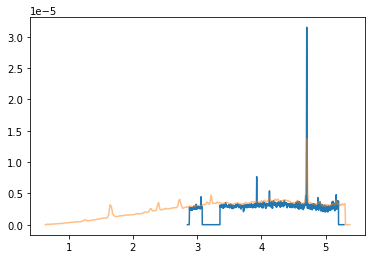

In [11]:
Table5 = Table.read('jw04233003002_PRIMER-UDS-7_2_3-gaia_F290LP_G395M_s00006_x1d.fits')
Table10 = Table.read('jw04233003002_PRIMER-UDS-7_2_3-gaia_CLEAR_PRISM_s00161_x1d.fits')
plt.plot(Table5['WAVELENGTH'], Table5['FLUX'])
plt.plot(Table10['WAVELENGTH'], Table10['FLUX'], alpha = 0.5)

In [34]:
# Table7 = Table.read('jw04233004002_PRIMER-UDS-7_2_3-gaia_CLEAR_PRISM_s32488_x1d.fits')
# plt.plot(Table7['WAVELENGTH'], Table7['FLUX'])
# Table9 = Table.read('jw04233004002_PRIMER-UDS-7_2_3-gaia_F290LP_G395M_s32488_x1d.fits')
# plt.plot(Table9['WAVELENGTH'], Table9['FLUX'], alpha = 0.5)
# #plt.xlim(4.95, 5.3)
# plt.title("MSA_ID 32488")

Text(0.5, 1.0, 'MSA_ID 217')

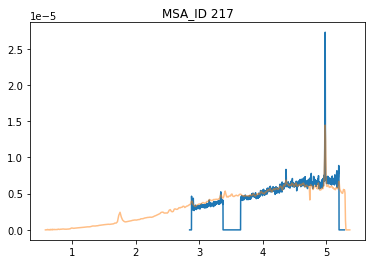

In [12]:
Table8 = Table.read('jw04233003002_PRIMER-UDS-7_2_3-gaia_F290LP_G395M_s00051_x1d.fits')
Table11 = Table.read('jw04233003002_PRIMER-UDS-7_2_3-gaia_CLEAR_PRISM_s00217_x1d.fits')
plt.plot(Table8['WAVELENGTH'], Table8['FLUX'])
plt.plot(Table11['WAVELENGTH'], Table11['FLUX'], alpha = 0.5)
# plt.xlim(4.9,5.2)
plt.title("MSA_ID 217")

In [21]:
# take all pasdchen alpha sources (or could see paschen alpha) from vital's catalog
# when they are found on the ceers data and tgere us a match in WFSS, see if you can match the lines too and compare


# make the initial sigmas and intitial wavelength bound wider, if you are selecting based on pixels
# look to switching to velocity space

In [14]:
C_20196 = Table.read('A_F356W_GRISMC_20196.V5.fits') #RUBIES-EGS-29489
R_20196 = Table.read('A_F356W_GRISMR_20196.V5.fits')

In [23]:
# def flux_conversion(flux_freq, wavelength):
#     '''
#     converts flux density per unit freq to flux denisty per unit wavelength 
#     args:
#         flux_freq (float): flux density per unit frequency [Jy] --> [ergs/(s*cm^2*Hz)]
#         wavelength (float): wavelength at the measured flux [A]
#     returns (float): flux density per unit wavelength [erg/(s*cm^2*A)]
#     '''
#     flux_freq = (10**-23) * flux_freq               # [Jy] --> [ergs/(s*cm^2*Hz)]
#     c = 2.99702547*(10**18)                         # [A/s]
#     flux_wav = (flux_freq * c) / (wavelength**2)    # [ergs/(s*cm^2*Hz)] --> [erg/(s*cm^2*A)]
#     return flux_wav

In [57]:
# plt.plot(R_20196['WAVELENGTH'], R_20196['FLUX'], alpha=.6, color = 'red'), plt.xlim(3.2,3.9), plt.ylim(-.75e-18, .75e-18), plt.title("20196")
# plt.show()
# plt.plot(C_20196['WAVELENGTH'], C_20196['FLUX'], color = 'blue'), plt.xlim(3.2,3.9), plt.ylim(-7e-19,7e-19)
# plt.show()

In [58]:
# line_window = 0.1
# check_wave, check_flux, check_flux_err, check_df = fitting_line(C_20196['WAVELENGTH'], C_20196['FLUX'], C_20196['FLUXERR'], 3.63, line_window, save=False, diagnose=True )

In [ ]:
# velocity space

# # def create_window(waves_fluxes_tuple, line_obs, velocity_window):
#     '''
#     creates a window around a certain value 
#     args:
#         waves_fluxes_tuple (tuple): tuple containing wavelength and flux values for a given galaxy spectrum
#         line_obs (float): emission line wavelength in the observed frame
#         velocity_window (int): value to set the size of the window (typical values range from 2000-3000 km/s)
#     returns (tuple): wavelength and flux values within the window for a given galaxy spectrum
#     '''
#     waves, fluxes = waves_fluxes_tuple
    
#     # creating window in velocity-space to search for emission lines (velocity space does not change with redshift)
#     delta_velocity = velocity_window  # [km/s]
#     c = 299792.458   # [km/s]
#     delta_lambda = (line_obs * delta_velocity) / c  # converting velocity-space window into wavelength units
#     # mask to cast onto wavelength and flux values
#     bool_arr = np.abs(np.array(waves) - line_obs) < delta_lambda
#     # window to search for peak
#     wave_window = waves[bool_arr]
#     flux_window = fluxes[bool_arr]
    
#     return wave_window, flux_window

In [31]:
C_34234 = Table.read('B_F356W_GRISMC_34234.V5.fits') #RUBIES-EGS-49140
R_34234 = Table.read('B_F356W_GRISMR_34234.V5.fits')

([<matplotlib.lines.Line2D at 0x7feb37595780>],
 (3.8, 3.9),
 (-7.5e-19, 7.5e-19))

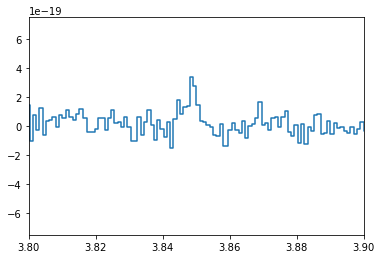

In [56]:
plt.step(R_34234['WAVELENGTH'], R_34234['FLUX'], where = 'mid'), plt.xlim(3.8,3.9), plt.ylim(-.75e-18, .75e-18)

3.85
Minimization Guesses
A: 3.357050251188598e-19
mu: 3.85
sigma: 0.07381377716546234
b: 1.6086024656827906e-20



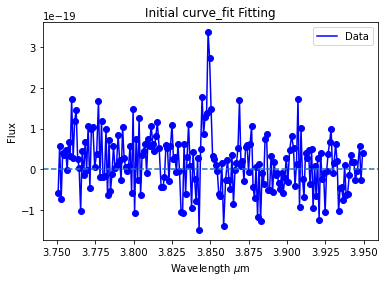

1.6086024656827906e-20
[0, 3.75, 0, 8.043012328413953e-21]
[3.357050251188598e-19, 3.85, 0.07381377716546234, 1.6086024656827906e-20]
[6.714100502377196e-19, 3.95, 0.1, 3.217204931365581e-20]
Minimization Results
A: 3.357050251188598e-19
mu: 3.85
sigma: 0.07381377716546234
b: 2.0107530821034882e-20



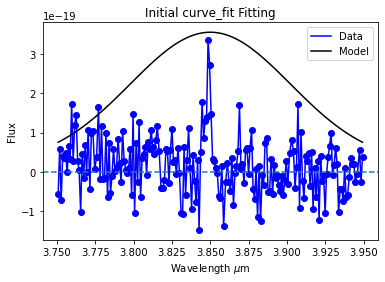

Checking the Walker Jumps


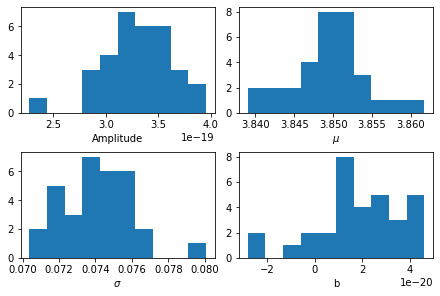

/opt/conda/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Checking Parameter Posterior Distributions


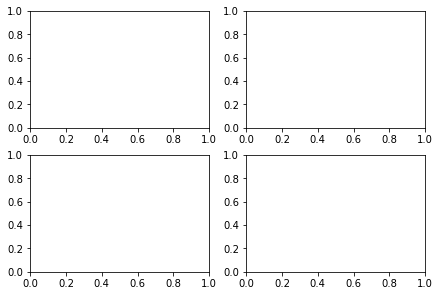

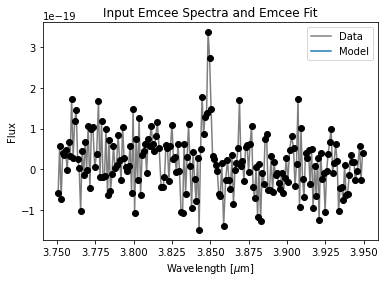

In [53]:
check_wave, check_flux, check_flux_err, check_df = fitting_line(R_34234['WAVELENGTH'], R_34234['FLUX'], R_34234['FLUXERR'], 3.85, line_window, save=False, diagnose=True )
# sigma is too big and not changing???
#meeting with oscar at 10am wednesday

In [3]:
x = np.linspace(1, 5, 1000)
arr = np.array([3.357050251188598e-19, 3.85, 0.07381377716546234, 2.0107530821034882e-20])

(3.7, 4.0)

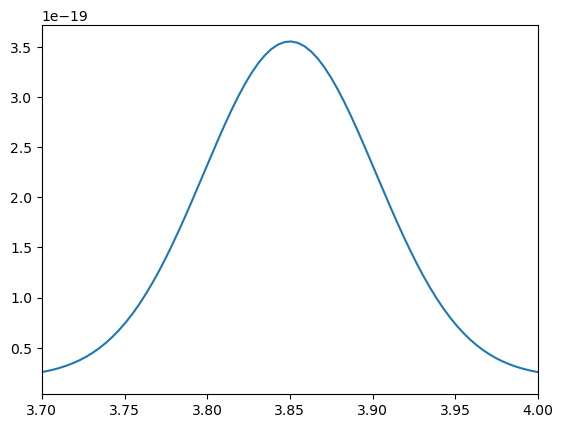

In [5]:
plt.plot(x, line_model(x, *arr))
plt.xlim(3.7, 4)